In [5]:
# Import required libraries for data manipulation and numerical operations
import pandas as pd
import numpy as np

In [6]:
# Define the time range for the analysis (years and quarters)
years = [2021, 2022, 2023, 2024]
quarters = ["Q1", "Q2", "Q3", "Q4"]

# Define manufacturers and relative growth strength
# Growth factors are used to simulate realistic differences in market performance
manufacturers = {
    "Tesla": 1.0,
    "BYD": 1.2,
    "Volkswagen": 0.7,
    "Hyundai": 0.65,
    "Ford": 0.5,
    "GM": 0.45
}

# Define high-level global regions for sales aggregation
regions = ["North America", "Europe", "China", "Asia ex-China"]


In [7]:
# Initialize a list to collect generated sales records
data = []

# Set random seed to ensure reproducibility of synthetic data
np.random.seed(42)

# Generate synthetic quarterly EV sales data across all dimensions
for year_index, year in enumerate(years):
    for quarter in quarters:
        for manufacturer, growth_factor in manufacturers.items():
            for region in regions:
                
                # Define a base sales value that increases year over year
                base_sales = 50 + (year_index * 15)
                
                # Apply regional multipliers to simulate geographic demand differences
                region_multiplier = {
                    "North America": 1.0,
                    "Europe": 0.9,
                    "China": 1.3 if manufacturer == "BYD" else 0.8,
                    "Asia ex-China": 0.7
                }
                
                # Add controlled random noise to avoid perfectly uniform patterns
                noise = np.random.normal(0, 5)
                
                # Calculate final sales value (in thousands of vehicles)
                sales = (
                    base_sales
                    * growth_factor
                    * region_multiplier[region]
                    + noise
                )
                
                # Append a single observation (one row) to the dataset
                data.append([
                    year,
                    quarter,
                    manufacturer,
                    region,
                    round(max(sales, 5), 1)
                ])

# Convert collected records into a Pandas DataFrame
df = pd.DataFrame(
    data,
    columns=["Year", "Quarter", "Manufacturer", "Region", "Sales_Thousands"]
)


In [8]:
# Verify dataset dimensions (rows and columns)
df.shape

(384, 5)

In [9]:
# Inspect a few rows to verify data looks reasonable
df.head()

,Year,Quarter,Manufacturer,Region,Sales_Thousands
0,2021,Q1,Tesla,North America,52.5
1,2021,Q1,Tesla,Europe,44.3
2,2021,Q1,Tesla,China,43.2
3,2021,Q1,Tesla,Asia ex-China,42.6
4,2021,Q1,BYD,North America,58.8


In [10]:
# Check for missing values across all columns
df.isnull().sum()

Year               0
Quarter            0
Manufacturer       0
Region             0
Sales_Thousands    0
dtype: int64

In [11]:
# Validate that all manufacturers are evenly represented
df["Manufacturer"].value_counts()

Manufacturer
Tesla         64
BYD           64
Volkswagen    64
Hyundai       64
Ford          64
GM            64
Name: count, dtype: int64

In [12]:
# Validate that all regions are evenly represented
df["Region"].value_counts()

Region
North America    96
Europe           96
China            96
Asia ex-China    96
Name: count, dtype: int64

In [13]:
# Confirm consistent data coverage across all years
df["Year"].value_counts().sort_index()

Year
2021    96
2022    96
2023    96
2024    96
Name: count, dtype: int64

In [14]:
# Review statistical summary of sales values to check ranges and distribution
df["Sales_Thousands"].describe()

count    384.000000
mean      48.103906
std       25.540551
min        8.400000
25%       29.650000
50%       42.650000
75%       59.275000
max      150.000000
Name: Sales_Thousands, dtype: float64

In [15]:
# Save the validated sales dataset to CSV for downstream analysis
df.to_csv(
    "../data/raw/ev_sales_quarterly_2021_2024.csv",
    index=False
)

In [16]:
# Aggregate total sales across all years, quarters, and regions by manufacturer
manufacturer_sales = (
    df.groupby("Manufacturer")["Sales_Thousands"]
      .sum()
      .sort_values(ascending=False)
)

manufacturer_sales

Manufacturer
BYD           5418.6
Tesla         3923.1
Volkswagen    2805.4
Hyundai       2525.4
Ford          2063.0
GM            1736.4
Name: Sales_Thousands, dtype: float64

Insight:
BYD has the highest total EV sales from 2021–2024 (~1.5M vehicles), followed by Tesla, based on aggregated quarterly sales data.

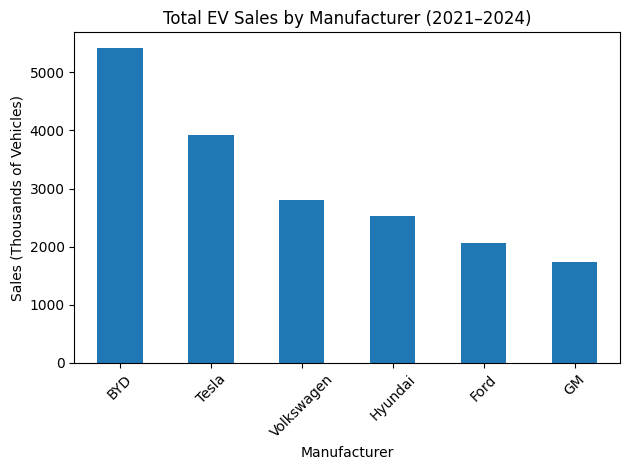

In [17]:
import matplotlib.pyplot as plt

# Plot total sales by manufacturer
manufacturer_sales.plot(kind="bar")

plt.title("Total EV Sales by Manufacturer (2021–2024)")
plt.ylabel("Sales (Thousands of Vehicles)")
plt.xlabel("Manufacturer")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig("../visuals/total_ev_sales_by_manufacturer.png")
plt.show()

What I learned so far:

1. I initially assumed that Tesla, as an early forerunner in the EV market, would dominate total sales across regions. However, the aggregated data shows that this assumption does not hold true for the 2021–2024 period.

2. BYD leads total EV sales with approximately 1.5 million vehicles, compared to Tesla’s lower total over the same time frame, indicating stronger overall sales volume during this period.

3. Comparing my initial expectation with the actual results helped highlight that early market entry does not always translate into the highest total sales over time, reinforcing the importance of validating assumptions with data.

In [18]:
# Total sales by Manufacturer and Year
mfr_year_sales = (
    df.groupby(["Manufacturer", "Year"], as_index=False)["Sales_Thousands"]
      .sum()
      .sort_values(["Year", "Sales_Thousands"],ascending=[True, False])
)

mfr_year_sales

,Manufacturer,Year,Sales_Thousands
0,BYD,2021,946.2
16,Tesla,2021,677.8
20,Volkswagen,2021,470.8
12,Hyundai,2021,392.7
4,Ford,2021,348.2
8,GM,2021,290.8
1,BYD,2022,1221.9
17,Tesla,2022,864.0
21,Volkswagen,2022,636.2
13,Hyundai,2022,570.8


In [21]:
# 1. Sort so YoY compares the correct previous year
mfr_year_sales = mfr_year_sales.sort_values(["Manufacturer", "Year"])

# 2. Calculate YoY growth
mfr_year_sales["YoY_Growth"] = (
    mfr_year_sales.groupby("Manufacturer")["Sales_Thousands"]
    .pct_change()
    .mul(100)
    .round(2)
)
mfr_year_sales

,Manufacturer,Year,Sales_Thousands,YoY_Growth
0,BYD,2021,946.2,NaN
1,BYD,2022,1221.9,29.14
2,BYD,2023,1471.3,20.41
3,BYD,2024,1779.2,20.93
4,Ford,2021,348.2,NaN
5,Ford,2022,452.8,30.04
6,Ford,2023,599.8,32.46
7,Ford,2024,662.2,10.40
8,GM,2021,290.8,NaN
9,GM,2022,412.8,41.95


In [22]:
# Ensure Year is numeric
mfr_year_sales["Year"] = mfr_year_sales["Year"].astype(int)

# Sort correctly for line plotting
mfr_year_sales = mfr_year_sales.sort_values(["Manufacturer", "Year"])

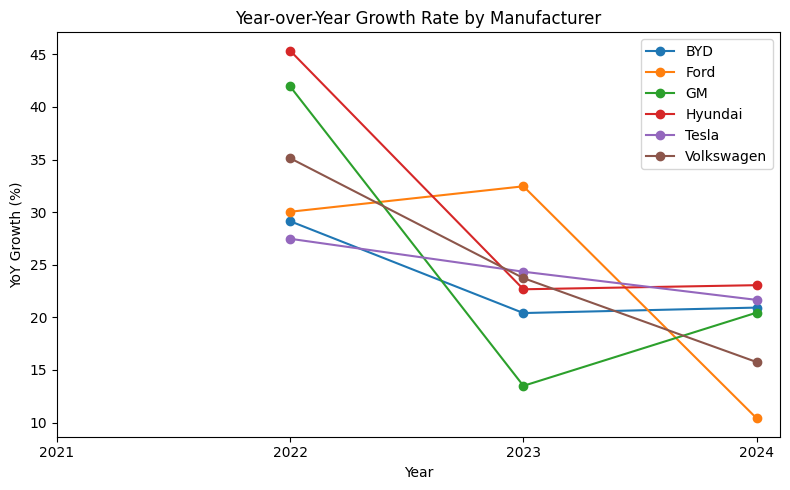

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 5))

for mfr in mfr_year_sales["Manufacturer"].unique():
    subset = mfr_year_sales[mfr_year_sales["Manufacturer"] == mfr]
    plt.plot(subset["Year"], subset["YoY_Growth"], marker="o", label=mfr)

years_sorted = sorted(mfr_year_sales["Year"].unique())
plt.xticks(years_sorted)

plt.title("Year-over-Year Growth Rate by Manufacturer")
plt.xlabel("Year")
plt.ylabel("YoY Growth (%)")
plt.legend()
plt.tight_layout()
plt.savefig("../visuals/yoy_growth_by_manufacturer.png")
plt.show()


* Over time, the year-over-year growth rate declines relative to each manufacturer’s prior-year growth, indicating a general moderation in growth across the market.

* Tesla and BYD exhibit more consistent growth patterns, while other manufacturers show higher volatility with sharper fluctuations in YoY growth.

* For manufacturers with volatile growth patterns, longer-term observation is necessary to distinguish temporary fluctuations from sustained performance trends.